In [36]:
import pint; from pint import UnitRegistry; AQ = UnitRegistry(system='atomic').Quantity
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

### The reference system (from the Continuum paper)

In [37]:
sigma_0 = 0.19
c_r = 0.0025
D = AQ(2e-4,'micrometer^2/microsecond')
nukin = AQ(0.16,'1/second')
sigma_I_corner = .20
beta = 0.65
Nbar = 1
Nstar = 0.14

### Geometry of the facet

In [38]:
npts = 500
midpt = np.round(npts/2).astype(int)
L = AQ(25,'micrometer')
x = np.linspace(-L,L,npts)

### Using the dimensionless x-parameter to compute $N_{SS}$
As defined by Eq. 20 of the paper,

$$
N_{SS} = M {v_{kin}L^2c_r^\beta \sigma_{I,corner}\over D} + B
$$

x(ref) = 0.002035452657684521 dimensionless
x(ref,Fig11) = 2.035452657684521 dimensionless
NSS(Standard state) = 8.395722175748206 dimensionless


<IPython.core.display.Javascript object>


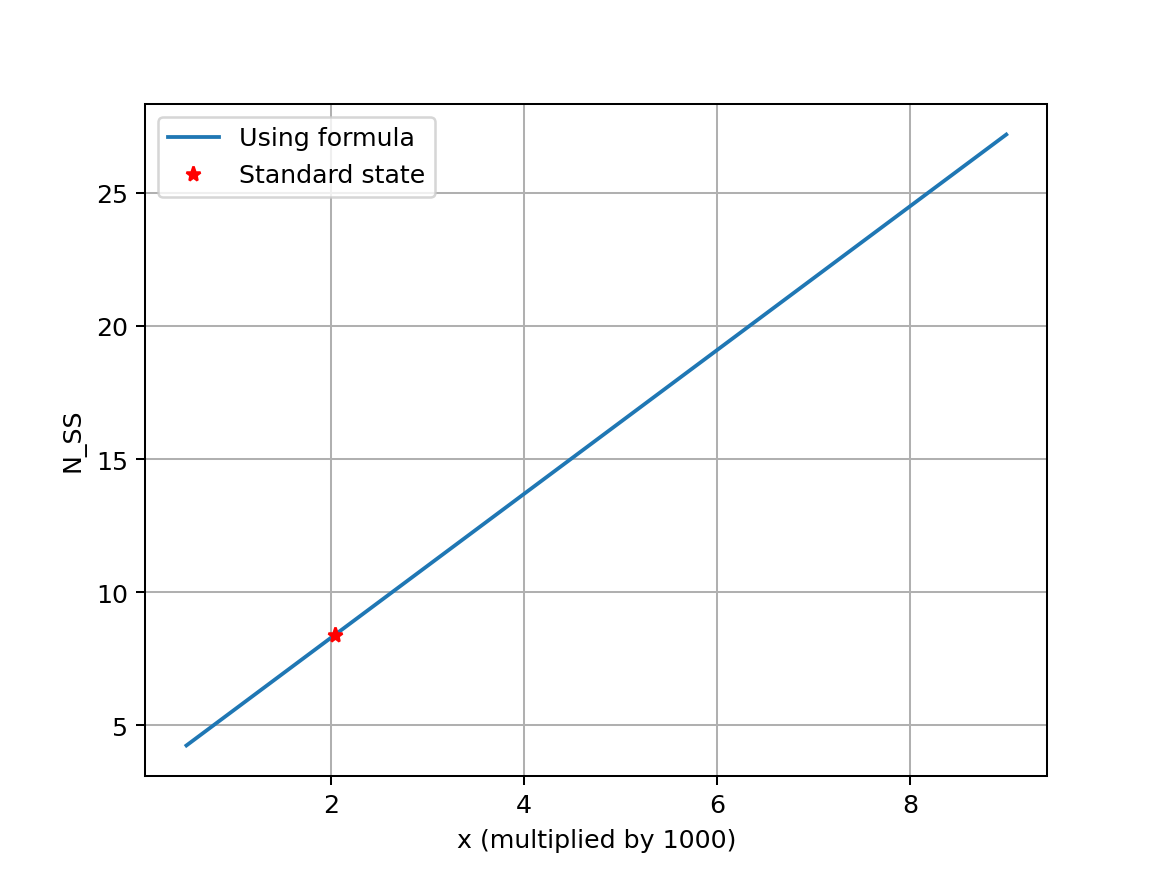

In [39]:
xparameter_ref = nukin*L**2*c_r**beta*sigma_I_corner/D
xparameter_ref.ito('dimensionless')
print('x(ref) =', xparameter_ref)

xparameter_ref_Fig11 = xparameter_ref*1e3
print('x(ref,Fig11) =', xparameter_ref_Fig11)

Iwantsinusoidal = True
if Iwantsinusoidal:
    M = 0.0027*1e6
    B = 2.9
else:
    M = 0.0025*1e6
    B = 1.6    

NSS_ref = M*xparameter_ref+B
print('NSS(Standard state) =', NSS_ref)

xparameter_Fig11 = np.linspace(0.5,9)
xparameter = xparameter_Fig11/1e3
NSS = M*xparameter+B

plt.figure()
plt.plot(xparameter_Fig11,NSS,label='Using formula')
plt.plot(xparameter_ref_Fig11,NSS_ref,'r*',label='Standard state')
plt.grid(True)
plt.xlabel('x (multiplied by 1000)')
plt.ylabel('N_SS')
plt.legend()

### Computing the shape of the inhomogeneous water vapor field
Equation 13 of the paper says
$$
\sigma_l(x) = \sigma_{l,corner} \times f_{inhomog}(x)
$$

where we have our choice between the sinusoidal form, Eq. 14,
$$
f_{inhomog}(x) = f_{sinusoidal}(x) = 1 - c_r\bigl [1 + cos\bigl ({x \over L}\pi \bigr) \bigr ] /2
$$

or the parabolic form,

$$
f_{inhomog}(x) = f_{parabolic}(x) = c_r\bigl({x \over L} \bigr )^2 + (1-c_r)
$$

It's also going to be convenient to define

$$
\delta \sigma_l(x) = \sigma_{l,corner}  \times \delta f_{inhomog}(x)
$$

where

$$
\delta f_{inhomog}(x) = f_{inhomog} - 1
$$

<IPython.core.display.Javascript object>


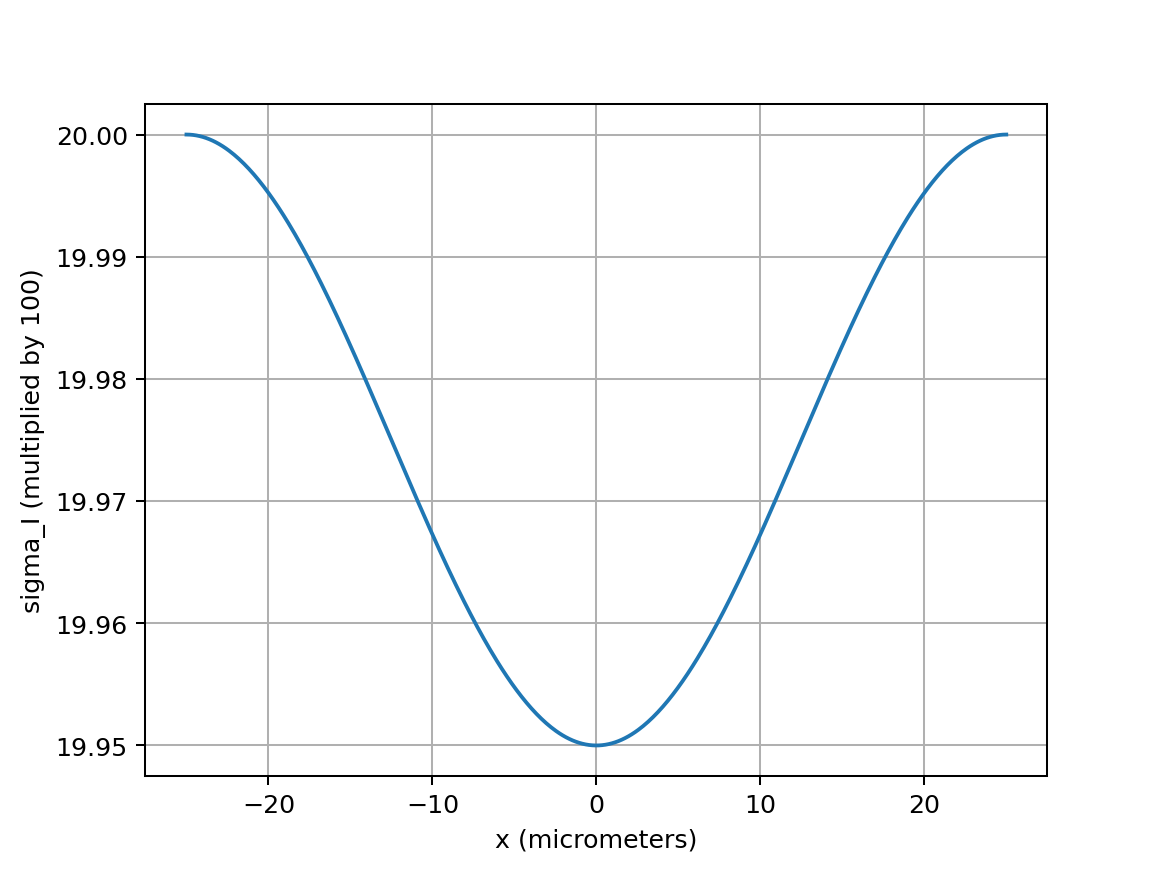

<IPython.core.display.Javascript object>


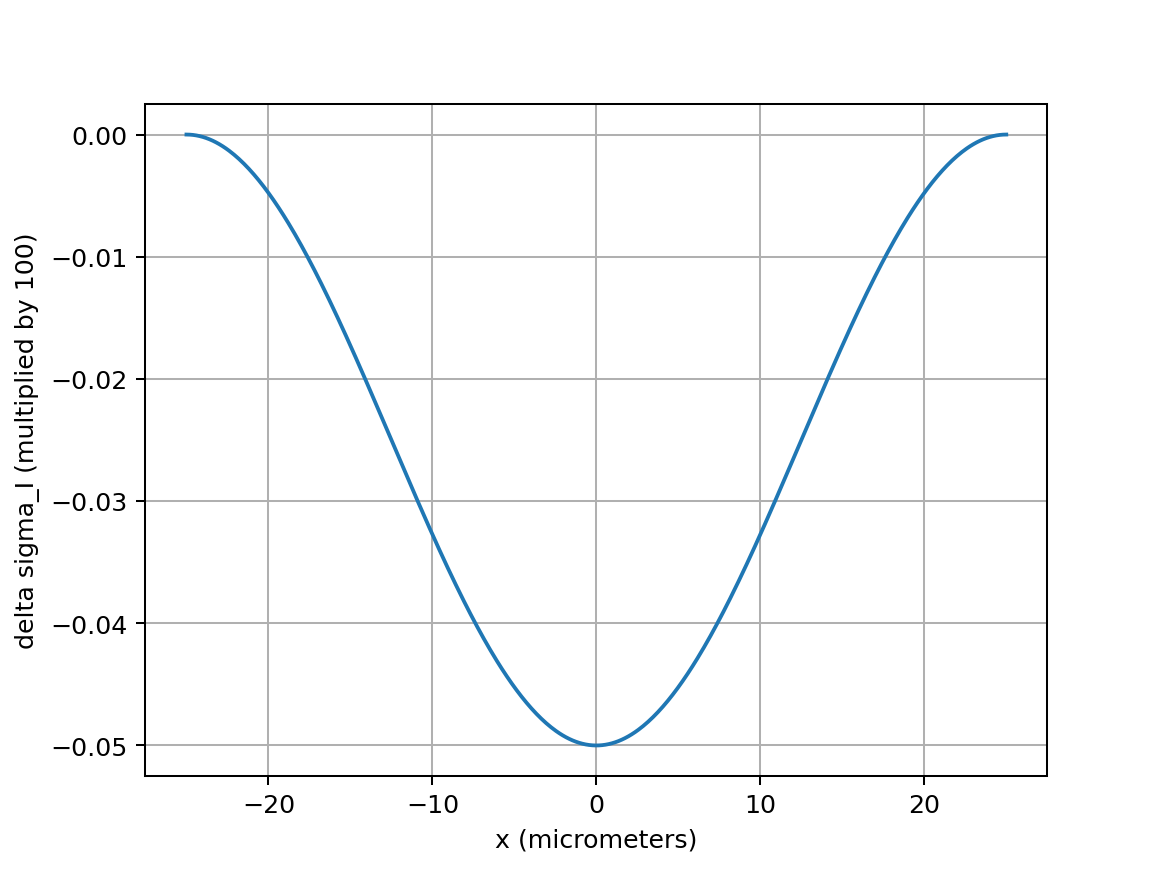

In [40]:
if Iwantsinusoidal:
    f_inhomog = 1 - c_r * (1+np.cos(x/L*np.pi))/2
else:
    f_inhomog = c_r * (x/L)**2 + (1-c_r)
fp_inhomog = f_inhomog - 1


delta_sigma_I = sigma_I_corner*fp_inhomog
sigma_I = sigma_I_corner*f_inhomog

plt.figure()
plt.plot(x,sigma_I*100)
plt.xlabel('x (micrometers)')
plt.ylabel('sigma_I (multiplied by 100)')
plt.grid(True)

plt.figure()
plt.plot(x,delta_sigma_I*100)
plt.xlabel('x (micrometers)')
plt.ylabel('delta sigma_I (multiplied by 100)')
plt.grid(True)

### Constructing the shape of the steady-state profile
We'll start with the idea that we can reconstruct an approximate surface, $N_{ice}(x)$, using its slope,

$$
N_{ice}(x) = \int_{-L}^{x}{\partial N_{ice}\over \partial x}dx \ \ \ \ (1)
$$

The integrand is a function of the step width, $w$,

$$
{\partial N_{ice}\over \partial x} = \mp {1 \over w} \ \ \ \ (2)
$$

in which the sign choice is determined by whether $x$ lies to the left or right of facet center. Once ${\partial N_{ice}\over \partial x}$ is determined, we can use Eq. 1 to find $N_{ice}(x)$.

### A very rough approximation
Let's claim that the step width is related to the imposed supersaturation according to $w \approx \mp {c' \over \sqrt{ -{\delta(\sigma_I) } }}$. Then 

$$
{\partial N_{ice}\over \partial x} \approx \mp {\sqrt{ -{\delta(\sigma_I) } } \over c'} \ \ \ \ (3)
$$

where (once we've integrated, according to Eq. 1), we'll assign a value of $c'$ so that $N_{ice}$ goes from zero to $N_{SS}$ of the standard system. This approach is implemented in the cell below.

<IPython.core.display.Javascript object>


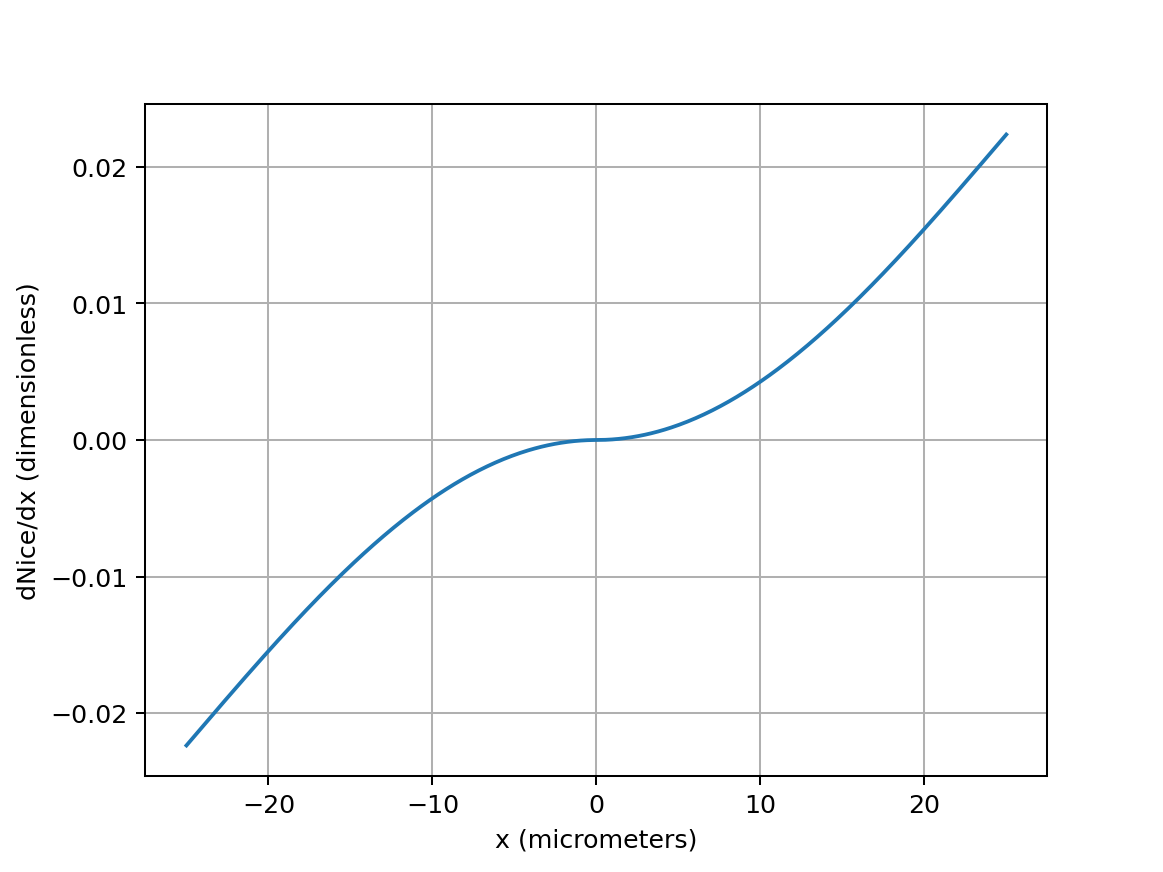

Range of Nice before scaling =  0.20425439745045343 micrometer
cprime =  0.024328389288590387 micrometer
Units of Nice = dimensionless


<IPython.core.display.Javascript object>


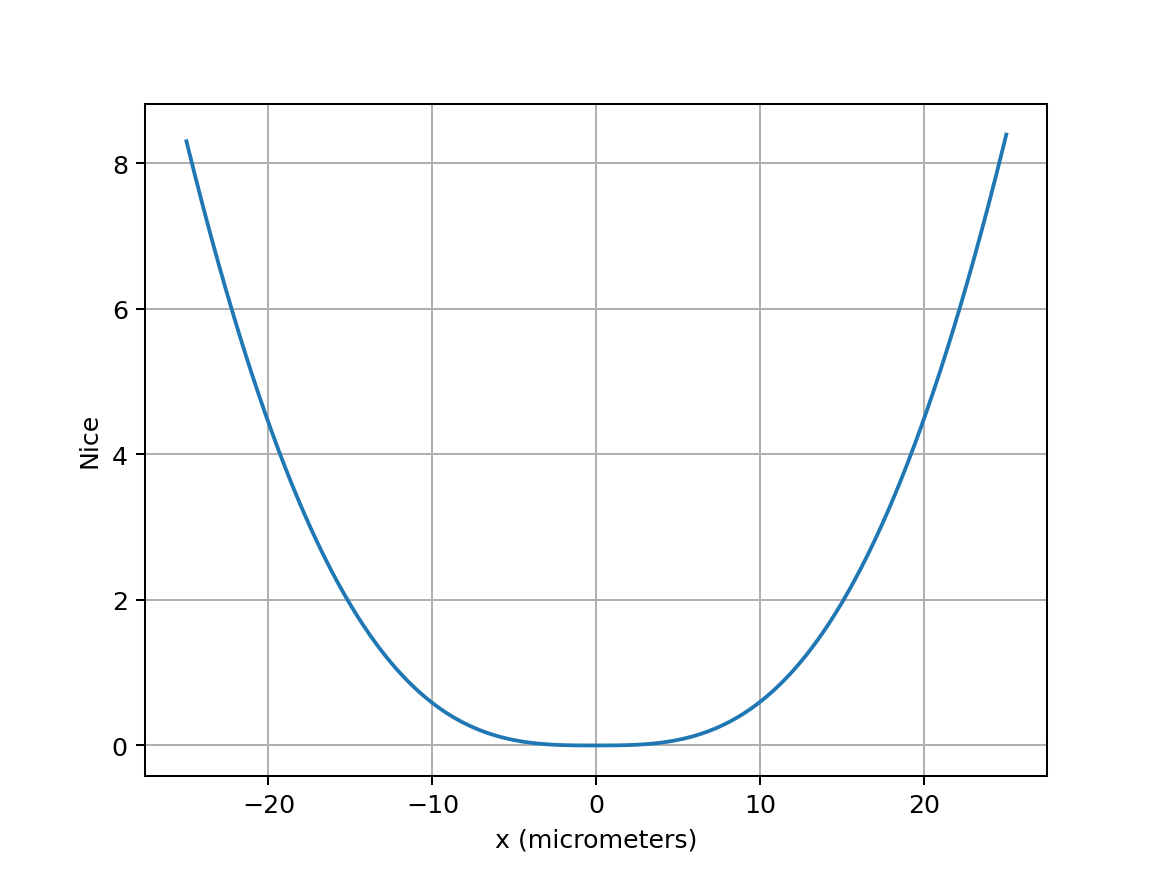

In [41]:
arg_of_sqrt = -delta_sigma_I
result_of_sqrt = np.sqrt(arg_of_sqrt)
Nicep = result_of_sqrt-np.max(result_of_sqrt)
for i in range(len(Nicep)):
    if x[i].magnitude > 0:
        Nicep[i] = -Nicep[i]
plt.figure()
plt.plot(x,Nicep)
plt.xlabel('x (micrometers)')
plt.ylabel('dNice/dx ('+str(Nicep.units)+')')
plt.grid(True)
 
dx = x[1]-x[0]
Nice = np.cumsum(Nicep)*dx
Nice -= np.min(Nice)
print('Range of Nice before scaling = ', np.max(Nice) )
cprime = np.max(Nice)/NSS_ref
print('cprime = ', cprime)
Nice /= cprime
print('Units of Nice =', Nice.units)

plt.figure()
plt.plot(x,Nice)
plt.xlabel('x (micrometers)')
plt.ylabel('Nice')
plt.grid(True)

### Pause for analysis
The $N_{ice}(x)$ just displayed looks surprisingly faithful to our numerical results -- say, Fig. 9 of the paper. 

### Another very rough approximation
Now let's claim that the step width is related to the imposed supersaturation according to $w \approx \mp {c'  \over \delta(\sigma_I)}$. Then 

$$
{\partial N_{ice}\over \partial x} \approx \pm { {\delta(\sigma_I) }  \over c'} \ \ \ \ (3)
$$

where (once we've integrated, according to Eq. 1), we'll assign a value of $c'$ so that $N_{ice}$ goes from zero to $N_{SS}$ of the standard system. This approach is implemented in the cell below.

<IPython.core.display.Javascript object>


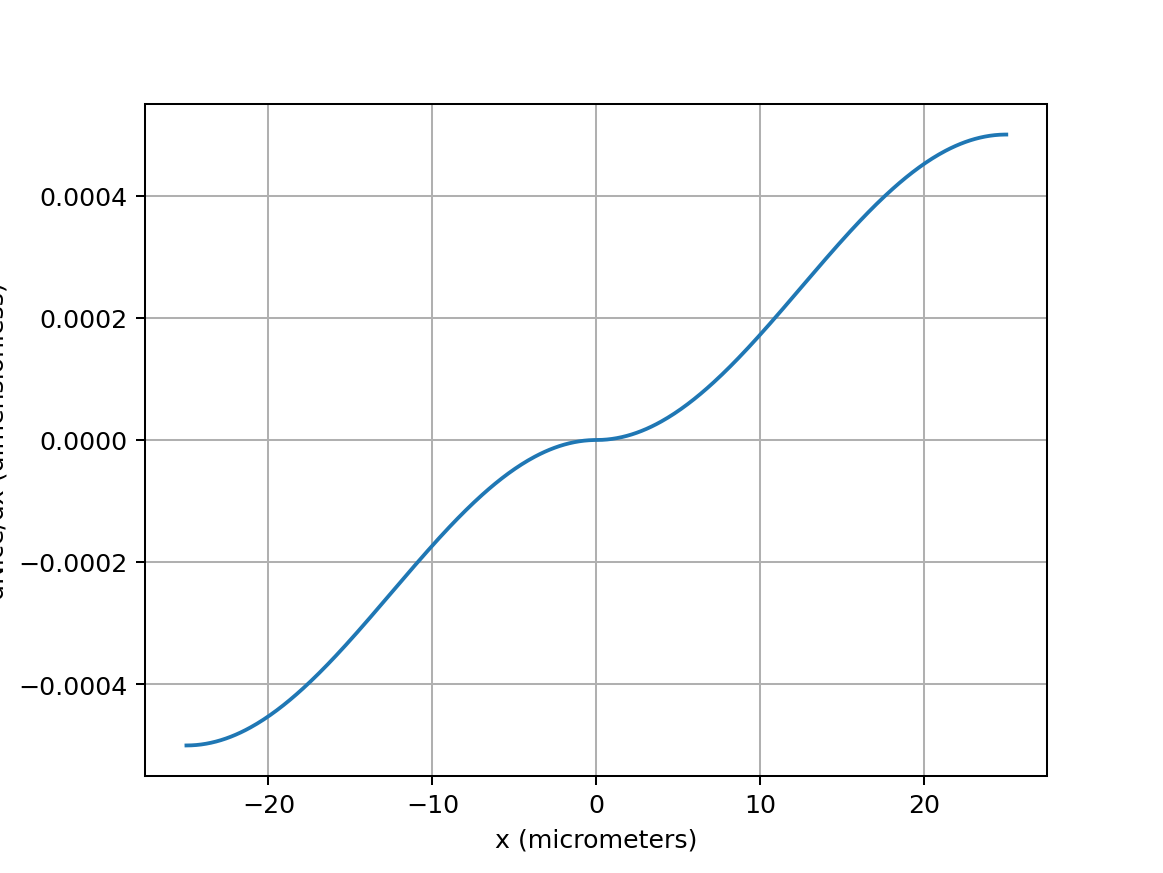

Range of Nice2 before scaling =  0.0062749259873643055 micrometer
cprime2 =  0.0007473956207710148 micrometer
Units of Nice2 = dimensionless


<IPython.core.display.Javascript object>


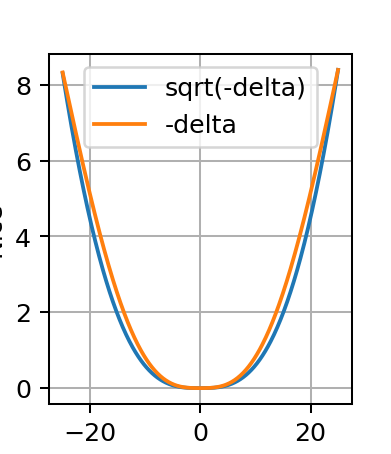

In [47]:
# Nicep = delta_sigma_I-np.max(delta_sigma_I)
Nice2p = -delta_sigma_I
Nice2pmax = np.max(Nice2p)
Nice2p -= Nice2pmax
for i in range(len(Nice2p)):
    if x[i].magnitude > 0:
        Nice2p[i] = -Nice2p[i]
plt.figure()
plt.plot(x,Nice2p)
plt.xlabel('x (micrometers)')
plt.ylabel('dNice/dx ('+str(Nice2p.units)+')')
plt.grid(True)
 
dx = x[1]-x[0]
Nice2 = np.cumsum(Nice2p)*dx
Nice2 -= np.min(Nice2)
print('Range of Nice2 before scaling = ', np.max(Nice2) )
cprime2 = np.max(Nice2)/NSS_ref
print('cprime2 = ', cprime2)
Nice2 /= cprime2
print('Units of Nice2 =', Nice2.units)

plt.figure()
plt.plot(x,Nice, label='sqrt(-delta)')
plt.plot(x,Nice2,label='-delta')
plt.xlabel('x (micrometers)')
plt.ylabel('Nice')
plt.grid(True)
plt.legend()

### Former (probably irrelevant) notes
We'll start with the idea that we can reconstruct an approximate surface, $N_{ice}(x)$, using its slope,

$$
N_{ice}(x) = \int_{-L}^{x}{\partial N_{ice}\over \partial x}dx \ \ \ \ (1)
$$

The integrand is a function of the step width, $w$,

$$
{\partial N_{ice}\over \partial x} = \mp {1 \over w} \ \ \ \ (2)
$$

in which the sign choice is determined by whether $x$ lies to the left or right of facet center. According to Eq. 25 of the paper, we have

$$
w^2 = {k F(\sigma_I) \over \delta(\sigma_m) \ \nu_{kin}} \ \ \ \ (3)
$$

where $k$ is defined in Eq. 26,

$$
k = {D \ \sigma_o \ \nu_{kin} \over 2 N^*} \ \ \ \ (4)
$$

and $F(\sigma_I)$ is defined in Eq. 27 (and displayed in Fig. 12). These combine to form

$$
{\partial N_{ice}\over \partial x}
= \sqrt{ {\delta(\sigma_m) \nu_{kin}} \over k F(\sigma_I) }
= \sqrt{ {\delta(\sigma_m) } 2 N^* \over D \sigma_o F(\sigma_I) } \ \ \ \ (5)
$$

Once ${\partial N_{ice}\over \partial x}$ is determined, we can use Eq. 1 to find $N_{ice}(x)$.

In [43]:
# F = AQ(-1,'second')
# arg_of_sqrt = delta_sigma_L * 2 * Nstar / (D*sigma_0*F)
# arg_of_sqrt.ito('1/micrometer^2')
# print(arg_of_sqrt.units)
# result_of_sqrt = np.sqrt(arg_of_sqrt)
# print(result_of_sqrt.units)

# Nicep_1 = result_of_sqrt
# Nicep = Nicep_1-np.max(Nicep_1)
# for i in range(len(Nicep)):
#     if x[i].magnitude > 0:
#         Nicep[i] = -Nicep[i]
# plt.figure()
# plt.plot(x,Nicep)
# plt.xlabel('x (micrometers)')
# plt.ylabel('dNice/dx ('+str(Nicep.units)+')')
# plt.grid(True)
 
# dx = x[1]-x[0]
# Nice = np.cumsum(Nicep)*dx
# Nice -= np.min(Nice)
# cprime = NSS_ref/np.max(Nice)
# print(cprime)
# Nice *= cprime

# plt.figure()
# plt.plot(x,Nice)
# plt.xlabel('x (micrometers)')
# plt.ylabel('Nice')
# plt.grid(True)

### Predicting stability to perturbations

In [44]:
# f_ss = Nice
# l = L

# eps = 1
# n = 0
# f_perturbation = eps*np.cos((n+.5)*np.pi*x/l)
# f_perturbed = f_ss + f_perturbation
# plt.figure()
# plt.plot(x,f_ss,'k',label='steady-state facet')
# plt.plot(x,f_perturbed,'b',label='perturbed steady state')
# plt.grid(True)
# plt.xlabel('x (um)')
# plt.ylabel('Nice')
# plt.legend()
# f_perturbed_original = f_perturbed

In [45]:
# slope_ss_squared = np.gradient(f_ss,dx,edge_order=2)**2
# growth_factor2 = AQ(2,'micrometer^2')
# growth_factor = np.sqrt(growth_factor2)
# f_perturbed = f_perturbed_original

# for i in range(4):
#     print(i)
#     slope_perturbed_squared =  np.gradient(f_perturbed,dx,edge_order=2)**2

#     plt.figure()
#     plt.plot(x,slope_ss_squared,'k',label='steady state')
#     plt.plot(x,slope_perturbed_squared,'b',label='perturbed')
#     plt.grid(True)
#     plt.legend()
#     plt.title('squared slopes')

#     f2_deviation = slope_perturbed_squared - slope_ss_squared
#     plt.figure()
#     plt.plot(x,f2_deviation,'--',label='perturbed - ss')
#     plt.grid(True)
#     plt.legend()
#     plt.title('f2_deviation')

#     correction = growth_factor2*f2_deviation

#     f_perturbed_later = f_perturbed + correction
#     shift = np.mean(f_ss-f_perturbed_later)
#     f_perturbed_later += shift
#     plt.figure()
#     plt.plot(x,f_ss,'k',label='steady state')
#     plt.plot(x,f_perturbed,'b',label='perturbed with low-frequency noise')
#     plt.plot(x,f_perturbed_later,'b--',label='recovery based on diffusive slowdown heuristic')
#     plt.grid(True)
#     plt.xlabel('x (um)')
#     plt.ylabel('Ice layers')
#     plt.legend()

#     plt.figure()
#     real_correction = f_perturbed_later - f_perturbed
#     plt.plot(x,f_perturbation*real_correction,'b',label='correlation')
#     plt.grid(True)
#     plt.title('Correlation < 0 => autocorrects')
#     plt.legend()

#     f_perturbed = f_perturbed_later    